# Analysis Overview

Contains the training and testing of the various ensemble-of-decision-tree models, as well as the figures from the CNNs (which are in separate notebooks due to being run on Google Colab).

### Setup and Initial Exploration

In [2]:
# Imports
import json
from datetime import datetime, timedelta
from dateutil import parser
from sqlite3 import dbapi2 as sql
import collections
import itertools

import matplotlib.pyplot as plt

from sklearn.ensemble import VotingClassifier
from sklearn import tree
from sklearn import metrics
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.metrics import brier_score_loss
from sklearn.calibration import calibration_curve

from xgboost import XGBClassifier

import pandas as pd
import numpy as np

In [15]:
# Helper functions

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix')

    print(cm.__repr__())

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

In [3]:
# Set up the database connection
con = sql.connect("events.db")
cur = con.cursor()

In [4]:
# DB Columns
columns = ['year', 'month', 'day', 'hour', 'slice_id', 'mode', 'centroid_latitude', 'centroid_longitude', 
           'area', 'solidity', 'minor_axis_length', 'major_axis_length', 'convex_area', 'eccentricity', 
           'mean_intensity', 'max_intensity', 'intense_area', 'convective_area', 'intense_total_ratio', 
           'convective_total_ratio', 'intense_convective_ratio', 'intensity_variance', 
           'max_characteristic_curvature', 'mean_characteristic_curvature',
           'max_mean_characteristic_curvature', 'normalized_cell_count', 
           'convective_solidity', 'convective_length_width_ratio', 'parallel_stratiform_distance', 
           'normal_stratiform_distance', 'convective_length', 'convective_width', 'stratiform_width', 
           'stratiform_convective_width_ratio', 'system_convective_length_ratio', 'delaunay_edges', 
           'edge_proportion_min_is_none', 'edge_proportion_min_is_stratiform', 
           'edge_proportion_min_is_convective', 'edge_proportion_mean_is_none', 
           'edge_proportion_mean_is_stratiform', 'edge_proportion_mean_is_convective', 
           'edge_proportion_mean_is_intense', 'edge_mean_length', 'cell_centroid_spread',
           'cell_centroid_r_square', 'labeled_by', 'labeled_at']
base_features = ['area', 'solidity', 'minor_axis_length', 'major_axis_length', 'convex_area',
            'eccentricity', 'mean_intensity', 'max_intensity', 'intense_area', 'convective_area',
            'intense_total_ratio', 'convective_total_ratio', 'intense_convective_ratio',
            'intensity_variance']
all_features = ['area', 'solidity', 'minor_axis_length', 'major_axis_length', 'convex_area', 'eccentricity', 
           'mean_intensity', 'max_intensity', 'intense_area', 'convective_area', 'intense_total_ratio', 
           'convective_total_ratio', 'intense_convective_ratio', 'intensity_variance', 
           'max_characteristic_curvature', 'mean_characteristic_curvature',
           'max_mean_characteristic_curvature', 'normalized_cell_count',
           'convective_solidity', 'convective_length_width_ratio', 'parallel_stratiform_distance', 
           'normal_stratiform_distance', 'convective_length', 'convective_width', 'stratiform_width', 
           'stratiform_convective_width_ratio', 'system_convective_length_ratio', 'delaunay_edges', 
           'edge_proportion_min_is_none', 'edge_proportion_min_is_stratiform', 
           'edge_proportion_min_is_convective', 'edge_proportion_mean_is_none', 
           'edge_proportion_mean_is_stratiform', 'edge_proportion_mean_is_convective', 
           'edge_proportion_mean_is_intense', 'edge_mean_length', 'cell_centroid_spread',
           'cell_centroid_r_square']

# Modes (note: merging TRP with SYN and removing CLT for prelim results)
labels = ['IC', 'CC', 'BL', 'NS', 'LS', 'PS', 'TS', 'BE', 'NL', 'SYN']

In [5]:
df = pd.read_sql_query('SELECT * FROM slices_reprocessed WHERE mode IS NOT NULL AND mode != "OUT" and mode != "BAD" and mode !="CLT"', con)
df.replace('TRP', 'SYN', inplace=True)
df.head(5)

,year,month,day,hour,slice_id,mode,centroid_latitude,centroid_longitude,area,solidity,...,edge_proportion_min_is_none,edge_proportion_min_is_stratiform,edge_proportion_min_is_convective,edge_proportion_mean_is_none,edge_proportion_mean_is_stratiform,edge_proportion_mean_is_convective,edge_proportion_mean_is_intense,edge_mean_length,cell_centroid_spread,cell_centroid_r_square
0,2015,5,23,22,0,PS,37.359857,262.662953,144304,0.593004,...,0.714286,0.285714,0.0,0.371429,0.585714,0.042857,0.0,141.463079,130.0,0.407098
1,2007,5,1,4,1,NL,35.263388,264.736012,14224,0.822958,...,0.000000,1.000000,0.0,0.000000,1.000000,0.000000,0.0,83.581347,46.0,0.000000
2,2016,9,25,8,1,TS,37.799329,262.938583,12548,0.687336,...,0.533333,0.466667,0.0,0.133333,0.800000,0.066667,0.0,63.862084,10.0,0.670842
3,2005,8,27,14,0,NS,45.659332,275.253723,52280,0.484307,...,0.813953,0.186047,0.0,0.325581,0.674419,0.000000,0.0,114.433505,63.5,0.806568
4,2005,8,27,14,1,PS,34.969775,269.317857,27724,0.582976,...,0.814815,0.185185,0.0,0.444444,0.481481,0.074074,0.0,93.645967,112.5,0.315000


In [6]:
df

,year,month,day,hour,slice_id,mode,centroid_latitude,centroid_longitude,area,solidity,...,edge_proportion_min_is_none,edge_proportion_min_is_stratiform,edge_proportion_min_is_convective,edge_proportion_mean_is_none,edge_proportion_mean_is_stratiform,edge_proportion_mean_is_convective,edge_proportion_mean_is_intense,edge_mean_length,cell_centroid_spread,cell_centroid_r_square
0,2015,5,23,22,0,PS,37.359857,262.662953,144304,0.593004,...,0.714286,0.285714,0.000000,0.371429,0.585714,0.042857,0.000000,141.463079,130.0,0.407098
1,2007,5,1,4,1,NL,35.263388,264.736012,14224,0.822958,...,0.000000,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000,83.581347,46.0,0.000000
2,2016,9,25,8,1,TS,37.799329,262.938583,12548,0.687336,...,0.533333,0.466667,0.000000,0.133333,0.800000,0.066667,0.000000,63.862084,10.0,0.670842
3,2005,8,27,14,0,NS,45.659332,275.253723,52280,0.484307,...,0.813953,0.186047,0.000000,0.325581,0.674419,0.000000,0.000000,114.433505,63.5,0.806568
4,2005,8,27,14,1,PS,34.969775,269.317857,27724,0.582976,...,0.814815,0.185185,0.000000,0.444444,0.481481,0.074074,0.000000,93.645967,112.5,0.315000
5,2014,8,23,5,0,TS,41.455306,260.109873,124540,0.629499,...,0.506849,0.493151,0.000000,0.232877,0.684932,0.082192,0.000000,95.787769,146.0,0.184195
6,2014,6,15,10,0,TS,41.774538,265.120762,260308,0.473508,...,0.824818,0.175182,0.000000,0.459854,0.518248,0.021898,0.000000,157.393473,183.5,0.675597
7,2014,9,1,1,1,CC,43.567981,258.879271,16844,0.699850,...,0.818182,0.181818,0.000000,0.181818,0.727273,0.090909,0.000000,72.193333,42.5,0.357882
8,2011,7,3,23,0,NL,38.526146,270.012952,98432,0.680851,...,0.412698,0.571429,0.015873,0.206349,0.761905,0.031746,0.000000,107.678137,94.5,0.361056
9,2016,9,9,4,0,TS,38.390719,263.601888,42080,0.640214,...,0.724138,0.241379,0.034483,0.206897,0.689655,0.103448,0.000000,79.517750,48.0,0.579673


In [6]:
collections.Counter(df['mode'])

Counter({'PS': 224,
         'NL': 361,
         'TS': 529,
         'NS': 213,
         'CC': 419,
         'IC': 267,
         'SYN': 174,
         'LS': 130,
         'BL': 304,
         'BE': 379})

In [7]:
collections.Counter(df['year'])

Counter({'2015': 253,
         '2007': 262,
         '2016': 251,
         '2005': 229,
         '2014': 213,
         '2011': 256,
         '2009': 219,
         '2008': 227,
         '2004': 216,
         '2010': 309,
         '2012': 198,
         '2006': 158,
         '2013': 209})

------

## HA18 Parameter Set

In [7]:
# Create the training and testing datasets
df_train = df[(df.year >= '2007')]
x_train = df_train[base_features].values
y_train = df_train['mode'].values

df_test = df[(df.year <= '2006')]
x_test = df_test[base_features].values
y_test = df_test['mode'].values

print('x_train', x_train.shape)
print('x_test', x_test.shape)

print(collections.Counter(y_train))

x_train (2397, 14)
x_test (603, 14)
Counter({'TS': 415, 'CC': 333, 'BE': 299, 'NL': 288, 'BL': 239, 'IC': 214, 'PS': 189, 'NS': 174, 'SYN': 137, 'LS': 109})


In [9]:
# Create the RF classifier
clf = RandomForestClassifier(n_estimators=1000, n_jobs=4, verbose=1)

In [10]:
clf.fit(x_train, y_train)

[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.3s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:    0.7s
[Parallel(n_jobs=4)]: Done 792 tasks      | elapsed:    1.2s
[Parallel(n_jobs=4)]: Done 1000 out of 1000 | elapsed:    1.5s finished


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=1000, n_jobs=4,
            oob_score=False, random_state=None, verbose=1,
            warm_start=False)

In [11]:
predicted = clf.predict(x_test)
expected = y_test

print("Classification report for classifier %s:\n%s\n"
      % (clf, metrics.classification_report(expected, predicted)))
print("Confusion matrix:\n%s" % metrics.confusion_matrix(expected, predicted))

[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done 792 tasks      | elapsed:    0.3s


Classification report for classifier RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=1000, n_jobs=4,
            oob_score=False, random_state=None, verbose=1,
            warm_start=False):
              precision    recall  f1-score   support

          BE       0.38      0.42      0.40        80
          BL       0.52      0.43      0.47        65
          CC       0.50      0.57      0.53        86
          IC       0.75      0.83      0.79        53
          LS       0.00      0.00      0.00        21
          NL       0.48      0.49      0.49        73
          NS       0.34      0.36      0.35        39
          PS       0.17      0.09      0.11        35
         SYN       0.82      0.84      0.83        3

[Parallel(n_jobs=4)]: Done 1000 out of 1000 | elapsed:    0.4s finished


In [12]:
importances = clf.feature_importances_

# Print the feature ranking
print("Feature ranking:")

for i, pair in enumerate(sorted(list(enumerate(importances)), key=lambda tup: tup[1], reverse=True)):
    print('{}\t{}\t{}'.format(i + 1, base_features[pair[0]], pair[1]))

Feature ranking:
1	area	0.09135026053975875
2	solidity	0.09041073376487707
3	convective_area	0.08853566028083508
4	eccentricity	0.07913428133400824
5	minor_axis_length	0.07764962590745686
6	intensity_variance	0.07217290925251187
7	convective_total_ratio	0.06986852786220996
8	major_axis_length	0.06891763532764043
9	convex_area	0.06811718823973419
10	mean_intensity	0.06705739189167771
11	intense_total_ratio	0.06261220996453366
12	intense_convective_ratio	0.06112878210755464
13	intense_area	0.06061799045428138
14	max_intensity	0.0424268030729198


In [13]:
# Create the classifiers
rfc = RandomForestClassifier(n_estimators=1000, n_jobs=4, verbose=0)
gbc = GradientBoostingClassifier(n_estimators=1000, learning_rate=0.1, verbose=0)
xgbc = XGBClassifier(n_estimators=1000, learning_rate=0.1, n_jobs=4, verbose=0)
vclf = VotingClassifier([('rf', rfc), ('gb', gbc), ('xg', xgbc)], voting='soft')

In [14]:
# Now, run the above for all our classifiers
cm_base_dt = dict()
for clf, label in zip([vclf, rfc, gbc, xgbc], ['ENS', 'RFC', 'GBC', 'XGBC']):
    
    clf.fit(x_train, y_train)
    
    predicted = clf.predict(x_test)
    expected = y_test

    print("Classification report for classifier %s:\n%s\n"
          % (label, metrics.classification_report(expected, predicted)))
    cm_base_dt[label] = metrics.confusion_matrix(expected, predicted)
    print("Confusion matrix:\n%s" % cm_base_dt[label])
    print('Accuracy: %s' % metrics.accuracy_score(expected, predicted))
    
    try:
        importances = clf.feature_importances_

        print("Feature ranking:")

        for i, pair in enumerate(sorted(list(enumerate(importances)), key=lambda tup: tup[1], reverse=True)):
            print('{}\t{}\t{}'.format(i + 1, base_features[pair[0]], pair[1]))
    except AttributeError:
        pass

Classification report for classifier ENS:
              precision    recall  f1-score   support

          BE       0.31      0.33      0.32        80
          BL       0.49      0.45      0.47        65
          CC       0.49      0.57      0.52        86
          IC       0.68      0.74      0.71        53
          LS       0.00      0.00      0.00        21
          NL       0.51      0.48      0.49        73
          NS       0.45      0.49      0.47        39
          PS       0.17      0.11      0.14        35
         SYN       0.78      0.76      0.77        37
          TS       0.35      0.39      0.37       114

   micro avg       0.45      0.45      0.45       603
   macro avg       0.42      0.43      0.43       603
weighted avg       0.44      0.45      0.45       603


Confusion matrix:
[[26  2  2  1  0  4  1  5  1 38]
 [ 0 29 13  9  0  0  7  4  0  3]
 [ 3 10 49  5  1  6  2  2  0  8]
 [ 0  2 11 39  0  0  1  0  0  0]
 [ 4  2  4  0  0  4  2  1  0  4]
 [ 7  1  7  1  

Confusion matrix
array([[26,  2,  2,  1,  0,  4,  1,  5,  1, 38],
       [ 0, 29, 13,  9,  0,  0,  7,  4,  0,  3],
       [ 3, 10, 49,  5,  1,  6,  2,  2,  0,  8],
       [ 0,  2, 11, 39,  0,  0,  1,  0,  0,  0],
       [ 4,  2,  4,  0,  0,  4,  2,  1,  0,  4],
       [ 7,  1,  7,  1,  0, 35,  3,  2,  3, 14],
       [ 2,  6,  2,  2,  0,  3, 19,  0,  0,  5],
       [ 8,  4,  4,  0,  0,  3,  2,  4,  1,  9],
       [ 1,  0,  2,  0,  0,  5,  0,  0, 28,  1],
       [33,  3,  7,  0,  4,  9,  5,  5,  3, 45]])
Confusion matrix
array([[36,  1,  2,  1,  0,  3,  4,  1,  1, 31],
       [ 0, 26, 15,  8,  0,  0, 10,  2,  0,  4],
       [ 3,  8, 47,  7,  0,  6,  2,  3,  0, 10],
       [ 0,  3,  4, 45,  0,  0,  1,  0,  0,  0],
       [ 2,  1,  2,  0,  0,  2,  1,  1,  0, 12],
       [ 8,  2,  8,  1,  1, 37,  3,  1,  3,  9],
       [ 3,  5,  3,  2,  0,  5, 14,  0,  0,  7],
       [ 7,  3,  5,  0,  0,  4,  1,  3,  0, 12],
       [ 1,  0,  2,  0,  0,  3,  0,  0, 31,  0],
       [26,  3,  7,  0,  3,  9,  5

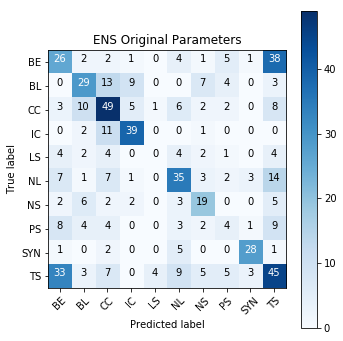

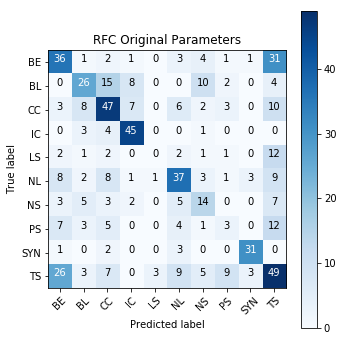

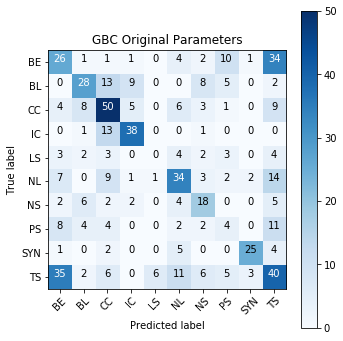

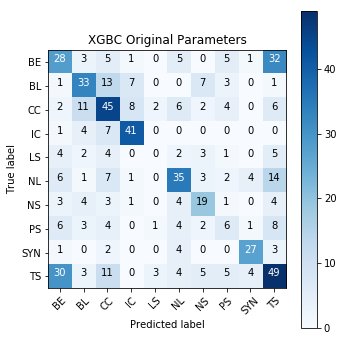

In [41]:
# Create the figures
for label in ['ENS', 'RFC', 'GBC', 'XGBC']:
    plt.figure(figsize=(5,5))
    plot_confusion_matrix(cm_base_dt[label], classes=sorted(labels), title=label + ' Original Parameters', cmap='Blues')
    plt.savefig("cm_{}_original.pdf".format(label), bbox_inches='tight')

------

## Full Parameter Set

In [17]:
# Create the training and testing datasets
df_train = df[(df.year >= '2007')]
x_train = df_train[all_features].values
y_train = df_train['mode'].values

df_test = df[(df.year <= '2006')]
x_test = df_test[all_features].values
y_test = df_test['mode'].values

print('x_train', x_train.shape)
print('x_test', x_test.shape)

print(collections.Counter(y_train))

x_train (2397, 38)
x_test (603, 38)
Counter({'TS': 415, 'CC': 333, 'BE': 299, 'NL': 288, 'BL': 239, 'IC': 214, 'PS': 189, 'NS': 174, 'SYN': 137, 'LS': 109})


In [18]:
# Create the RF classifier
clf = RandomForestClassifier(n_estimators=1000, n_jobs=4, verbose=1)

In [19]:
clf.fit(x_train, y_train)

[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.4s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:    0.9s
[Parallel(n_jobs=4)]: Done 792 tasks      | elapsed:    1.6s
[Parallel(n_jobs=4)]: Done 1000 out of 1000 | elapsed:    2.1s finished


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=1000, n_jobs=4,
            oob_score=False, random_state=None, verbose=1,
            warm_start=False)

In [20]:
predicted = clf.predict(x_test)
expected = y_test

print("Classification report for classifier %s:\n%s\n"
      % (clf, metrics.classification_report(expected, predicted)))
print("Confusion matrix:\n%s" % metrics.confusion_matrix(expected, predicted))

[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done 792 tasks      | elapsed:    0.3s


Classification report for classifier RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=1000, n_jobs=4,
            oob_score=False, random_state=None, verbose=1,
            warm_start=False):
              precision    recall  f1-score   support

          BE       0.53      0.56      0.55        80
          BL       0.62      0.45      0.52        65
          CC       0.59      0.59      0.59        86
          IC       0.77      0.87      0.81        53
          LS       0.36      0.24      0.29        21
          NL       0.57      0.59      0.58        73
          NS       0.47      0.59      0.52        39
          PS       0.53      0.23      0.32        35
         SYN       0.88      0.81      0.85        3

[Parallel(n_jobs=4)]: Done 1000 out of 1000 | elapsed:    0.4s finished


In [21]:
importances = clf.feature_importances_

# Print the feature ranking
print("Feature ranking:")

for i, pair in enumerate(sorted(list(enumerate(importances)), key=lambda tup: tup[1], reverse=True)):
    print('{}\t{}\t{}'.format(i + 1, all_features[pair[0]], pair[1]))

Feature ranking:
1	convective_length	0.042075373845524656
2	stratiform_width	0.04152852234727647
3	convective_length_width_ratio	0.038842274473212854
4	eccentricity	0.037339721334289505
5	normal_stratiform_distance	0.03709589225402343
6	max_characteristic_curvature	0.03605436769026606
7	area	0.03530960500907984
8	normalized_cell_count	0.034561758821672395
9	intensity_variance	0.0343812529873129
10	solidity	0.03428416280954343
11	cell_centroid_r_square	0.032081423693584195
12	convective_width	0.030469254039375383
13	minor_axis_length	0.029928565272335315
14	convective_total_ratio	0.029427056149034996
15	intense_total_ratio	0.02934865801144563
16	intense_convective_ratio	0.02884560440135462
17	mean_intensity	0.02776064753922994
18	convective_area	0.027331484727602995
19	stratiform_convective_width_ratio	0.0272379824844939
20	edge_mean_length	0.026532318058857425
21	major_axis_length	0.02526073170400014
22	system_convective_length_ratio	0.0244181503480366
23	convective_solidity	0.02389345

In [22]:
# Create the classifiers
rfc = RandomForestClassifier(n_estimators=1000, n_jobs=4, verbose=0)
gbc = GradientBoostingClassifier(n_estimators=1000, learning_rate=0.1, verbose=0)
xgbc = XGBClassifier(n_estimators=1000, learning_rate=0.1, n_jobs=4, verbose=0)
vclf = VotingClassifier([('rf', rfc), ('gb', gbc), ('xg', xgbc)], voting='soft')

In [23]:
# Now, run the above for all our classifiers
cm_all_dt = dict()
for clf, label in zip([vclf, rfc, gbc, xgbc], ['ENS', 'RFC', 'GBC', 'XGBC']):
    
    clf.fit(x_train, y_train)
    
    predicted = clf.predict(x_test)
    expected = y_test

    print("Classification report for classifier %s:\n%s\n"
          % (label, metrics.classification_report(expected, predicted)))
    cm_all_dt[label] = metrics.confusion_matrix(expected, predicted)
    print("Confusion matrix:\n%s" % cm_all_dt[label])
    print('Accuracy: %s' % metrics.accuracy_score(expected, predicted))
    
    try:
        importances = clf.feature_importances_

        print("Feature ranking:")

        for i, pair in enumerate(sorted(list(enumerate(importances)), key=lambda tup: tup[1], reverse=True)):
            print('{}\t{}\t{}'.format(i + 1, all_features[pair[0]], pair[1]))
    except AttributeError:
        pass

Classification report for classifier ENS:
              precision    recall  f1-score   support

          BE       0.50      0.50      0.50        80
          BL       0.65      0.54      0.59        65
          CC       0.57      0.62      0.59        86
          IC       0.79      0.83      0.81        53
          LS       0.46      0.52      0.49        21
          NL       0.58      0.59      0.59        73
          NS       0.54      0.64      0.59        39
          PS       0.41      0.37      0.39        35
         SYN       0.88      0.81      0.85        37
          TS       0.58      0.56      0.57       114

   micro avg       0.59      0.59      0.59       603
   macro avg       0.60      0.60      0.60       603
weighted avg       0.60      0.59      0.59       603


Confusion matrix:
[[40  1  1  0  4  1  3  5  1 24]
 [ 0 35 16  2  1  1  6  2  0  2]
 [ 1  5 53  9  1 10  2  1  0  4]
 [ 0  3  5 44  0  1  0  0  0  0]
 [ 1  1  1  0 11  2  1  2  0  2]
 [ 5  2  8  1  

Confusion matrix
array([[40,  1,  1,  0,  4,  1,  3,  5,  1, 24],
       [ 0, 35, 16,  2,  1,  1,  6,  2,  0,  2],
       [ 1,  5, 53,  9,  1, 10,  2,  1,  0,  4],
       [ 0,  3,  5, 44,  0,  1,  0,  0,  0,  0],
       [ 1,  1,  1,  0, 11,  2,  1,  2,  0,  2],
       [ 5,  2,  8,  1,  3, 43,  1,  3,  2,  5],
       [ 3,  3,  1,  0,  2,  2, 25,  1,  0,  2],
       [ 4,  2,  2,  0,  0,  3,  4, 13,  0,  7],
       [ 0,  0,  3,  0,  0,  4,  0,  0, 30,  0],
       [26,  2,  3,  0,  2,  7,  4,  5,  1, 64]])
Confusion matrix
array([[45,  0,  0,  0,  3,  1,  4,  3,  1, 23],
       [ 0, 30, 15,  5,  1,  1,  9,  1,  0,  3],
       [ 2,  7, 51,  8,  1, 10,  3,  0,  0,  4],
       [ 0,  2,  4, 46,  0,  1,  0,  0,  0,  0],
       [ 2,  1,  1,  0,  5,  3,  1,  2,  0,  6],
       [ 4,  1,  8,  1,  2, 39,  2,  1,  3, 12],
       [ 2,  4,  1,  0,  1,  2, 23,  1,  0,  5],
       [ 8,  1,  2,  0,  0,  3,  3,  6,  0, 12],
       [ 1,  0,  3,  0,  0,  3,  0,  0, 30,  0],
       [22,  2,  3,  0,  2,  8,  3

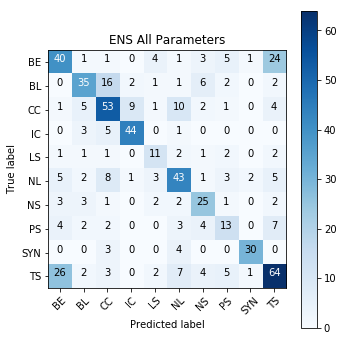

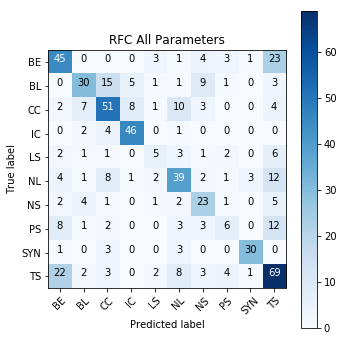

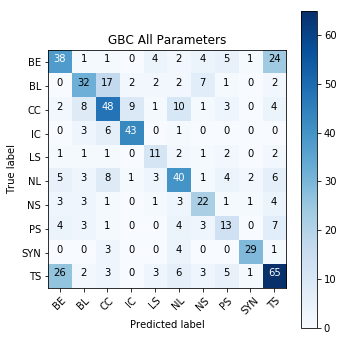

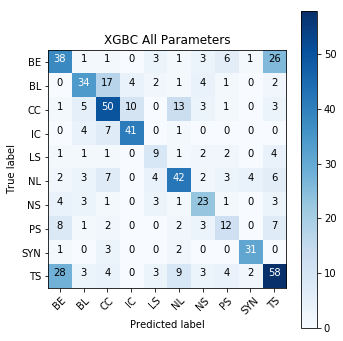

In [39]:
# Create the figures
for label in ['ENS', 'RFC', 'GBC', 'XGBC']:
    plt.figure(figsize=(5,5))
    plot_confusion_matrix(cm_all_dt[label], classes=sorted(labels), title=label + ' All Parameters', cmap='Blues')
    plt.savefig("cm_{}_full.pdf".format(label), bbox_inches='tight')

-----

# CNN Results

See

- [colab_cnn_scaled.ipynb](colab_cnn_scaled.ipynb)
- [colab_cnn_chopped.ipynb](colab_cnn_chopped.ipynb)
- [colab_cnn_4km_chopped.ipynb](colab_cnn_4km_chopped.ipynb)

Confusion matrix
array([[42,  1,  6,  0,  1,  3,  3,  4,  0, 20],
       [ 0, 10, 22, 10,  3,  2, 13,  0,  0,  5],
       [ 1,  1, 53,  7,  1, 19,  0,  1,  0,  3],
       [ 0,  2, 10, 41,  0,  0,  0,  0,  0,  0],
       [ 0,  4,  3,  2,  6,  3,  2,  1,  0,  0],
       [ 0,  1, 12,  1,  2, 50,  0,  0,  0,  7],
       [ 5,  4,  2,  0,  4,  2, 15,  1,  0,  6],
       [ 5,  2,  2,  1,  1,  9,  3,  5,  0,  7],
       [ 2,  0,  9,  1,  0, 21,  1,  1,  1,  1],
       [37,  0,  4,  1,  0, 21,  2,  2,  0, 47]])


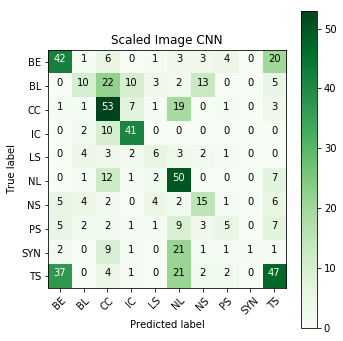

In [28]:
cm = np.array([[42,  1,  6,  0,  1,  3,  3,  4,  0, 20],
       [ 0, 10, 22, 10,  3,  2, 13,  0,  0,  5],
       [ 1,  1, 53,  7,  1, 19,  0,  1,  0,  3],
       [ 0,  2, 10, 41,  0,  0,  0,  0,  0,  0],
       [ 0,  4,  3,  2,  6,  3,  2,  1,  0,  0],
       [ 0,  1, 12,  1,  2, 50,  0,  0,  0,  7],
       [ 5,  4,  2,  0,  4,  2, 15,  1,  0,  6],
       [ 5,  2,  2,  1,  1,  9,  3,  5,  0,  7],
       [ 2,  0,  9,  1,  0, 21,  1,  1,  1,  1],
       [37,  0,  4,  1,  0, 21,  2,  2,  0, 47]])

plt.figure(figsize=(5,5))
plot_confusion_matrix(cm, classes=sorted(labels), title='Scaled Image CNN', cmap='Greens')
plt.savefig("cm_cnn_scaled.pdf", bbox_inches='tight')

Confusion matrix
array([[49,  0,  0,  0,  1,  0,  3,  1,  2, 24],
       [13,  6,  7,  0,  3,  1,  8,  8,  3, 16],
       [ 9,  4, 30,  0,  4,  4,  4, 10,  4, 17],
       [ 2,  5, 29, 12,  0,  2,  3,  0,  0,  0],
       [ 6,  2,  1,  0,  6,  0,  0,  2,  2,  2],
       [10,  4,  6,  0,  2, 10,  8,  5, 10, 18],
       [11,  2,  2,  0,  0,  1,  3,  4,  3, 13],
       [ 8,  1,  1,  0,  1,  0,  3,  8,  1, 12],
       [ 5,  1,  1,  0,  4,  3,  0,  2, 11, 10],
       [48,  0,  1,  0,  3,  2,  2,  5,  2, 51]])


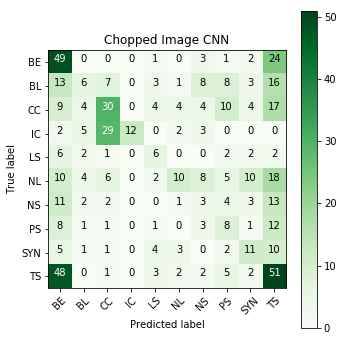

In [29]:
cm = np.array([[49,  0,  0,  0,  1,  0,  3,  1,  2, 24],
       [13,  6,  7,  0,  3,  1,  8,  8,  3, 16],
       [ 9,  4, 30,  0,  4,  4,  4, 10,  4, 17],
       [ 2,  5, 29, 12,  0,  2,  3,  0,  0,  0],
       [ 6,  2,  1,  0,  6,  0,  0,  2,  2,  2],
       [10,  4,  6,  0,  2, 10,  8,  5, 10, 18],
       [11,  2,  2,  0,  0,  1,  3,  4,  3, 13],
       [ 8,  1,  1,  0,  1,  0,  3,  8,  1, 12],
       [ 5,  1,  1,  0,  4,  3,  0,  2, 11, 10],
       [48,  0,  1,  0,  3,  2,  2,  5,  2, 51]])

plt.figure(figsize=(5,5))
plot_confusion_matrix(cm, classes=sorted(labels), title='Chopped Image CNN', cmap='Greens')
plt.savefig("cm_cnn_chopped.pdf", bbox_inches='tight')

Confusion matrix
array([[54,  0,  0,  0,  3,  0,  4,  3,  1, 15],
       [ 2,  0,  1,  3,  3,  3, 47,  2,  1,  3],
       [ 8,  1, 13,  3,  2, 21, 27,  1,  0, 10],
       [ 0,  0,  3, 32,  0,  2, 16,  0,  0,  0],
       [ 1,  0,  1,  0, 10,  0,  7,  1,  0,  1],
       [ 5,  1,  3,  0,  3, 26, 11,  1,  6, 17],
       [ 7,  0,  0,  0,  1,  1, 24,  3,  0,  3],
       [ 2,  2,  1,  0,  3,  2,  5, 14,  0,  6],
       [ 4,  1,  2,  0,  5,  7,  5,  1,  9,  3],
       [51,  0,  2,  0,  1,  3,  5,  4,  0, 48]])


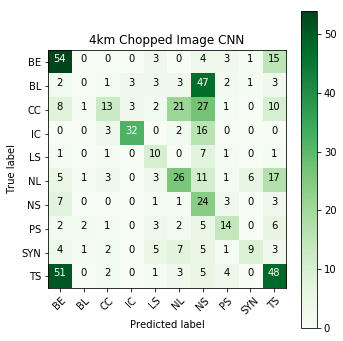

In [30]:
cm = np.array([[54,  0,  0,  0,  3,  0,  4,  3,  1, 15],
       [ 2,  0,  1,  3,  3,  3, 47,  2,  1,  3],
       [ 8,  1, 13,  3,  2, 21, 27,  1,  0, 10],
       [ 0,  0,  3, 32,  0,  2, 16,  0,  0,  0],
       [ 1,  0,  1,  0, 10,  0,  7,  1,  0,  1],
       [ 5,  1,  3,  0,  3, 26, 11,  1,  6, 17],
       [ 7,  0,  0,  0,  1,  1, 24,  3,  0,  3],
       [ 2,  2,  1,  0,  3,  2,  5, 14,  0,  6],
       [ 4,  1,  2,  0,  5,  7,  5,  1,  9,  3],
       [51,  0,  2,  0,  1,  3,  5,  4,  0, 48]])

plt.figure(figsize=(5,5))
plot_confusion_matrix(cm, classes=sorted(labels), title='4km Chopped Image CNN', cmap='Greens')
plt.savefig("cm_cnn_4km_chopped.pdf", bbox_inches='tight')

------

### Supplimentary Exploration

In [8]:
# Mode distribution breakdown between testing and training sets
for mode in labels:
    print(mode + '\t' + str(collections.Counter(y_test)[mode]) + '\t' + str(collections.Counter(y_train)[mode]))

IC	53	214
CC	86	333
BL	65	239
NS	39	174
LS	21	109
PS	35	189
TS	114	415
BE	80	299
NL	73	288
SYN	37	137
